<a href="https://colab.research.google.com/github/Arenaa/siamese-network/blob/main/Siamese_Network_for_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-dhgzo4ca
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-dhgzo4ca
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [17]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

fatal: destination path 'Person-Re-Id-Dataset' already exists and is not an empty directory.


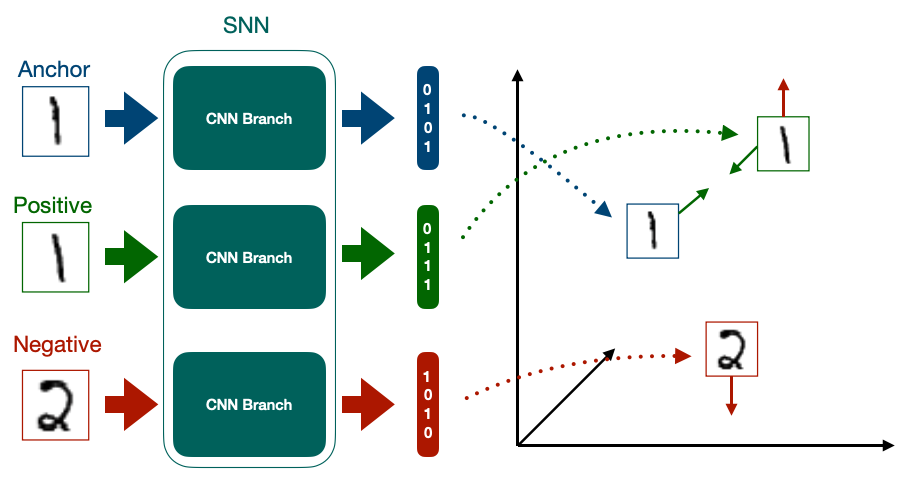

# Imports

In [18]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [19]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [20]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

batch_size = 32
learning_rate = 0.001
epochs = 15

device = 'cuda'

In [21]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [22]:
row = df.iloc[4]
anchor_img = io.imread(DATA_DIR + row.Anchor)
pos_img = io.imread(DATA_DIR + row.Positive)
neg_img = io.imread(DATA_DIR + row.Negative)

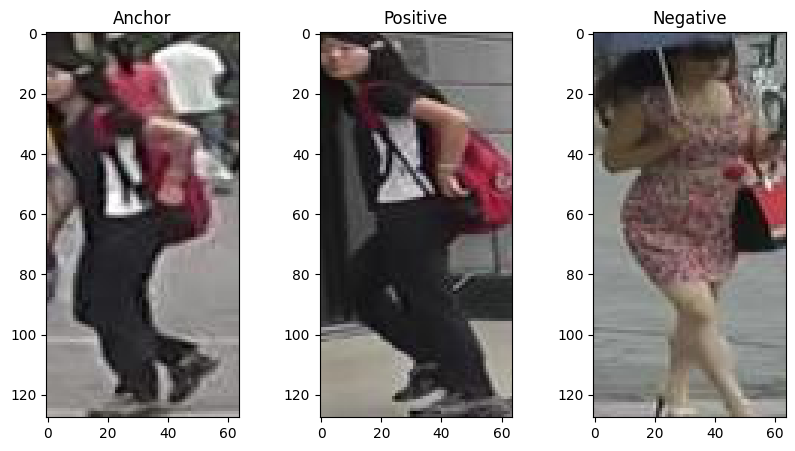

In [23]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title('Anchor')
ax1.imshow(anchor_img)

ax2.set_title('Positive')
ax2.imshow(pos_img)

ax3.set_title('Negative')
ax3.imshow(neg_img)

In [24]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Create APN Dataset 

In [48]:
class APN_Dataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = df.iloc[idx]

        anchor_img = io.imread(DATA_DIR + row.Anchor)
        pos_img = io.imread(DATA_DIR + row.Positive)
        neg_img = io.imread(DATA_DIR + row.Negative)

        anchor_img = torch.from_numpy(anchor_img).permute(2, 0, 1) /255.0
        pos_img = torch.from_numpy(pos_img).permute(2, 0, 1) /255.0
        neg_img = torch.from_numpy(neg_img).permute(2, 0, 1) /255.0

        return anchor_img, pos_img, neg_img

In [49]:
train_set = APN_Dataset(train_df)
valid_set = APN_Dataset(valid_df)

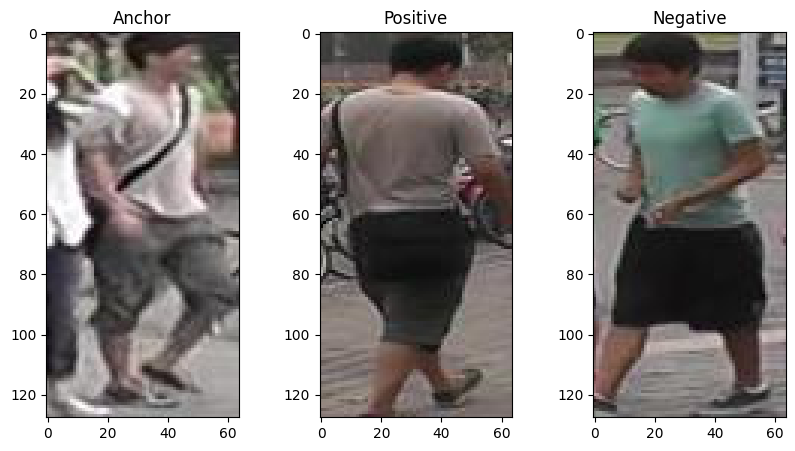

In [50]:
idx = 40
A,P,N = train_set[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [28]:
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_set, batch_size=batch_size)

In [29]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [30]:
for A, P , N in trainloader:
    break
    
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [31]:
class APN_Model(nn.Module):
    def __init__(self, emb_size=512):
        super().__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features,
                                                 out_features=emb_size)
    
    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings

In [32]:
model = APN_Model()
model.to(device);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


# Create Train and Eval function

In [33]:
def train_fn(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for A, P, N in tqdm(dataloader):
        A, P, N = A.to(device), P.to(device), N.to(device)

        A_embs = model(A)
        P_embd = model(P)
        N_embd = model(N)

        loss = criterion(A_embs, P_embd, N_embd)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss
        
    return total_loss / len(dataloader)


In [34]:
def eval_fn(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for A, P, N in tqdm(dataloader):
            A, P, N = A.to(device), P.to(device), N.to(device)

            A_embs = model(A)
            P_embd = model(P)
            N_embd = model(N)

            loss = criterion(A_embs, P_embd, N_embd)

            total_loss += loss

    return total_loss / len(dataloader)


In [35]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create Training Loop

In [51]:
best_valid_loss = np.Inf

for i in range(epochs):
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        best_valid_loss = valid_loss
        print('Save weight success')
    print(f'Epochs: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}')


100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Save weight success
Epochs: 1 train_loss: 0.058933075517416 valid_loss: 0.11688341200351715


100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


Epochs: 2 train_loss: 0.17207516729831696 valid_loss: 0.19269970059394836


100%|██████████| 25/25 [00:02<00:00,  9.13it/s]


Save weight success
Epochs: 3 train_loss: 0.11246265470981598 valid_loss: 0.04897705093026161


100%|██████████| 25/25 [00:02<00:00,  9.86it/s]


Save weight success
Epochs: 4 train_loss: 0.0504460483789444 valid_loss: 0.024072393774986267


100%|██████████| 25/25 [00:03<00:00,  7.95it/s]


Save weight success
Epochs: 5 train_loss: 0.02399495244026184 valid_loss: 0.013567606918513775


100%|██████████| 25/25 [00:02<00:00,  9.98it/s]


Save weight success
Epochs: 6 train_loss: 0.014338621869683266 valid_loss: 0.0015545764472335577


100%|██████████| 25/25 [00:03<00:00,  7.97it/s]


Epochs: 7 train_loss: 0.010827764868736267 valid_loss: 0.00787370279431343


100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


Epochs: 8 train_loss: 0.009701349772512913 valid_loss: 0.002929084934294224


100%|██████████| 25/25 [00:02<00:00,  8.99it/s]


Epochs: 9 train_loss: 0.012008165940642357 valid_loss: 0.004407250788062811


100%|██████████| 25/25 [00:02<00:00, 10.08it/s]


Epochs: 10 train_loss: 0.012493118643760681 valid_loss: 0.0037876134738326073


100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Epochs: 11 train_loss: 0.01627790369093418 valid_loss: 0.024554094299674034


100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Epochs: 12 train_loss: 0.01985604129731655 valid_loss: 0.0021449155174195766


100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Epochs: 13 train_loss: 0.04499795660376549 valid_loss: 0.012378373183310032


100%|██████████| 25/25 [00:02<00:00,  9.66it/s]


Epochs: 14 train_loss: 0.02884429320693016 valid_loss: 0.00535395136103034


100%|██████████| 25/25 [00:02<00:00, 10.18it/s]

Save weight success
Epochs: 15 train_loss: 0.013850044459104538 valid_loss: 0.0


# Get Anchor Embeddings

In [45]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
            A = A.to(device)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())
        
        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis=1)
    return df_enc



In [46]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:40<00:00, 97.75it/s]


In [47]:
df_enc.to_csv('database.csv', index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.295042,0.597216,-0.175155,0.044557,0.075702,0.567629,-0.258246,0.389590,-0.440031,...,-0.040219,-0.024071,0.328955,0.345898,-0.263456,-0.959188,-0.044221,0.372382,0.098564,-0.000992
1,1420_c3s3_061978_03.jpg,-0.294598,0.595499,-0.169107,0.046845,0.076272,0.562181,-0.254105,0.393616,-0.442010,...,-0.036452,-0.014144,0.330759,0.349935,-0.263358,-0.965708,-0.051141,0.384070,0.096187,0.001842
2,1420_c5s3_062565_05.jpg,-0.294025,0.596610,-0.173355,0.044110,0.077321,0.565459,-0.257139,0.388956,-0.440652,...,-0.039224,-0.022455,0.328306,0.344230,-0.263176,-0.955579,-0.044179,0.373869,0.096487,0.000035
3,1420_c6s3_085592_04.jpg,-0.294460,0.597065,-0.174382,0.043476,0.078195,0.568644,-0.259344,0.388441,-0.442867,...,-0.039588,-0.023731,0.327766,0.344819,-0.264657,-0.959991,-0.045382,0.376565,0.095089,-0.000082
4,0663_c5s3_085987_03.jpg,-0.297142,0.597865,-0.171154,0.044512,0.076583,0.572015,-0.262932,0.390591,-0.446514,...,-0.040230,-0.024435,0.331540,0.343914,-0.267838,-0.968726,-0.048889,0.386179,0.093335,-0.002289


# Inference

In [52]:
def ecludean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [53]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
    img = img.to(device)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [54]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [56]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = ecludean_dist(img_enc, anc_enc_arr[i: i+1, :1])
    distance = np.append(distance, dist)

In [57]:
closest_idx = np.argsort(distance)

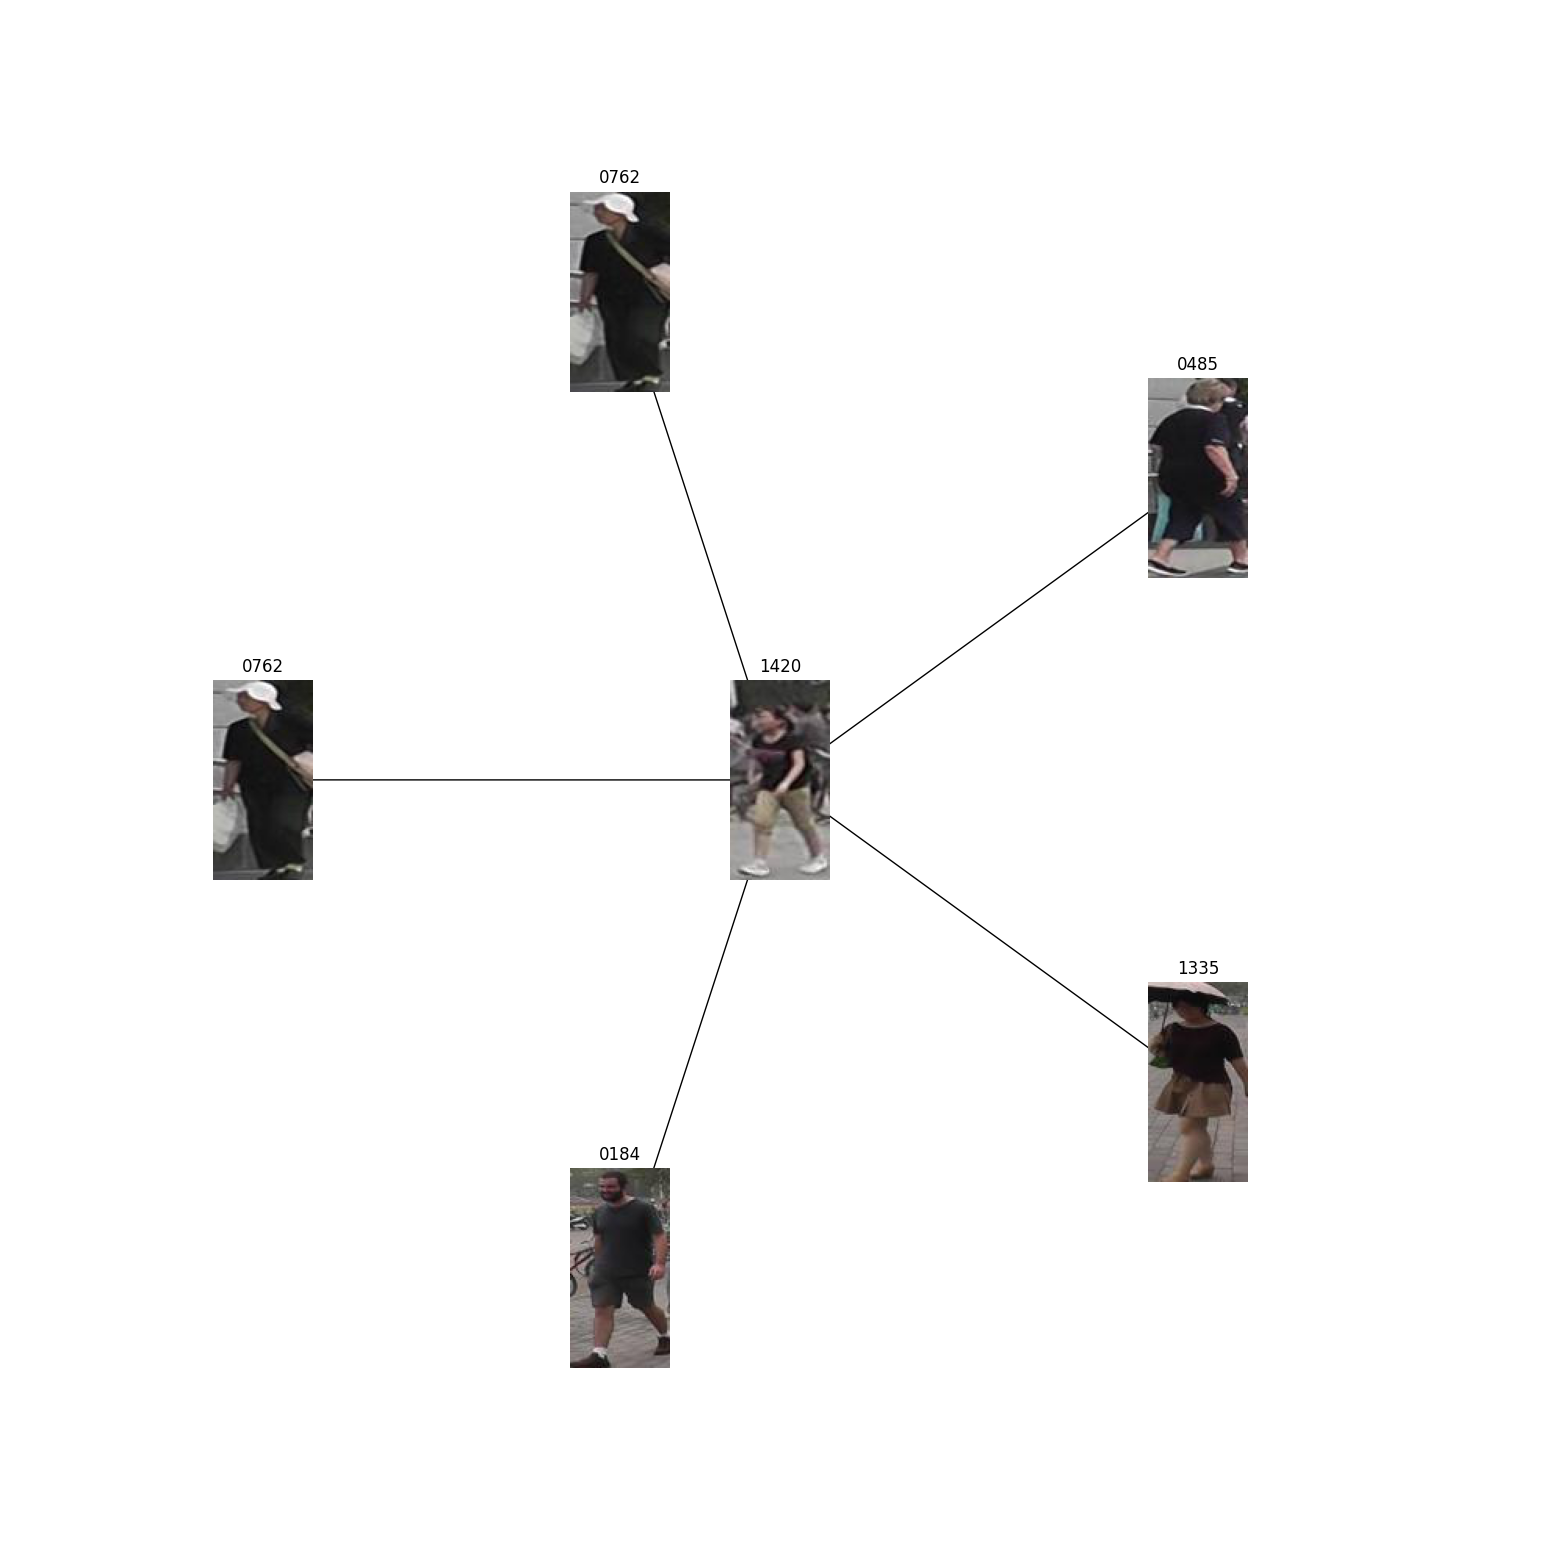

In [58]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);